In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim 
import torchvision 
from torchvision import datasets,models,transforms 
from torch.autograd import Variable 
import os 
import numpy as np 
import matplotlib.pyplot as plt 


In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [4]:
data_dir = "hymenoptera_data"

image_datasets = {x:datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x]) for x in ['train','val']}

dataloaders = {x:torch.utils.data.DataLoader(image_datasets[x],batch_size=4,shuffle=True,num_workers=4) for x in ['train','val']}

dataset_sizes = {x:len(image_datasets[x]) for x in ['train','val']}

class_names = image_datasets['train'].classes
print("Classes found on the train dataset are: ",class_names)
print("There are {} images in the train dataset".format(len(dataloaders['train'])))
print("There are {} images in the validation dataset".format(len(dataloaders['val'])))
print("There are {} images in the training_images".format(dataset_sizes['train']))
print("There are {} testing images".format(dataset_sizes['val']))


Classes found on the train dataset are:  ['ants', 'bees']
There are 61 images in the train dataset
There are 39 images in the validation dataset
There are 244 images in the training_images
There are 153 testing images


In [10]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x2ceca2c7130>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x2ceca2c6980>}

In [6]:
model_conv = torchvision.models.resnet18(True)

c:\Users\dhanu\miniconda3\envs\idk_gpu\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
c:\Users\dhanu\miniconda3\envs\idk_gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\dhanu/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:16<00:00, 2.78MB/s]


In [7]:
for param in model_conv.parameters():
    param.requires_grad = False

    

In [8]:
num_fltrs = model_conv.fc.in_features

model_conv.fc = nn.Linear(num_fltrs,len(class_names))

In [9]:
print(num_fltrs)
print(model_conv)

512
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True

In [11]:
if torch.cuda.is_available():
    model_conv = model_conv.cuda()

In [14]:
iter = 0
correct = 0
for inputs,labels in dataloaders['train']:
    if iter == 1:
        break
    inputs = Variable(inputs)
    labels = Variable(labels)
    if torch.cuda.is_available():
        inputs = inputs.cuda()
        labels = labels.cuda()
    print("For one iteration,this is what happens")
    print("Input shape: ",inputs.shape)
    print("Labels shape: ",labels.shape)
    output = model_conv(inputs)
    print("Output shape: ",output.shape)
    print("Output Tensor: ",output)
    _,predicted = torch.max(output,1)
    print("Predicted: ",predicted)
    print("Predicted Shape:",predicted.shape)
    correct += (predicted == labels).sum()
    iter += 1
    print("Correct: ",correct)

For one iteration,this is what happens
Input shape:  torch.Size([4, 3, 224, 224])
Labels shape:  torch.Size([4])
Output shape:  torch.Size([4, 2])
Output Tensor:  tensor([[-0.3301,  1.3339],
        [ 0.5642,  1.7098],
        [ 0.8452,  0.9333],
        [-0.0075,  1.6480]], device='cuda:0', grad_fn=<AddmmBackward0>)
Predicted:  tensor([1, 1, 1, 1], device='cuda:0')
Predicted Shape: torch.Size([4])
Correct:  tensor(4, device='cuda:0')


In [15]:
from torch.optim import lr_scheduler

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_conv.fc.parameters(),lr=0.001,momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)

In [18]:
def lr_scheduler(optimizer,epoch,init_lr=0.001,lr_decay_epoch=7):
    lr = init_lr*(0.1**(epoch//lr_decay_epoch))
    if epoch % lr_decay_epoch == 0:
        print("LR is set to {}".format(lr))
    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

In [20]:
num_epochs = 20
for epoch in range(num_epochs):
    corr = 0
    for images,labels in dataloaders['train']:
        images = Variable(images)
        labels = Variable(labels)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        optimizer.zero_grad()
        output = model_conv(images)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        _,predicted = torch.max(output,1)
        corr += (predicted == labels).sum()
        print("Epoch: {}/{}... ".format(epoch+1,num_epochs),
              "Loss: {:.4f}".format(loss.item()),
              "Accuracy: {:.2f}%".format(100*corr/len(dataloaders['train'])))
print('Training complete')

Epoch: 1/20...  Loss: 1.3022 Accuracy: 1.64%
Epoch: 1/20...  Loss: 0.8322 Accuracy: 3.28%
Epoch: 1/20...  Loss: 0.6557 Accuracy: 8.20%
Epoch: 1/20...  Loss: 0.7371 Accuracy: 11.48%
Epoch: 1/20...  Loss: 1.1091 Accuracy: 14.75%
Epoch: 1/20...  Loss: 0.8794 Accuracy: 18.03%
Epoch: 1/20...  Loss: 1.2134 Accuracy: 19.67%
Epoch: 1/20...  Loss: 0.2854 Accuracy: 26.23%
Epoch: 1/20...  Loss: 0.9022 Accuracy: 29.51%
Epoch: 1/20...  Loss: 0.7915 Accuracy: 32.79%
Epoch: 1/20...  Loss: 0.7954 Accuracy: 34.43%
Epoch: 1/20...  Loss: 0.4791 Accuracy: 39.34%
Epoch: 1/20...  Loss: 1.1111 Accuracy: 40.98%
Epoch: 1/20...  Loss: 0.5569 Accuracy: 44.26%
Epoch: 1/20...  Loss: 0.4812 Accuracy: 49.18%
Epoch: 1/20...  Loss: 0.8472 Accuracy: 52.46%
Epoch: 1/20...  Loss: 0.6064 Accuracy: 57.38%
Epoch: 1/20...  Loss: 0.6647 Accuracy: 62.30%
Epoch: 1/20...  Loss: 0.2045 Accuracy: 68.85%
Epoch: 1/20...  Loss: 0.3098 Accuracy: 73.77%
Epoch: 1/20...  Loss: 0.5670 Accuracy: 78.69%
Epoch: 1/20...  Loss: 0.5449 Accuracy

In [21]:
model_conv.eval()

with torch.no_grad():
    corr = 0 
    total = 0
    for (images,labels) in dataloaders['val']:
        images = Variable(images)
        labels = Variable(labels)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        outputs = model_conv(images)
        _,predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        corr += (predicted == labels).sum().item()
    print('Accuracy of the network on the test images: %d %%' % (100 * corr / total))


Accuracy of the network on the test images: 92 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


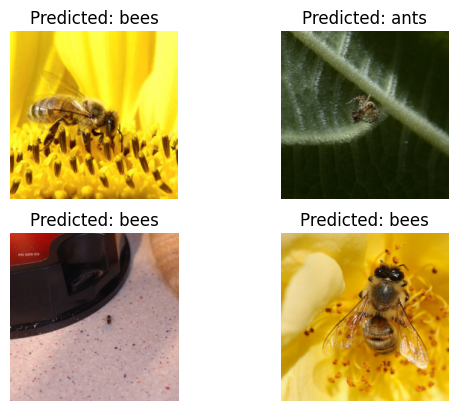

In [23]:
fig = plt.figure()
shown_batch = 0 
index = 0 
with torch.no_grad():
    for (images,labels) in dataloaders['val']:
        if shown_batch == 1:
            break 
        images = Variable(images)
        labels = Variable(labels)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        outputs = model_conv(images)
        _,predicted = torch.max(outputs.data,1)

        for i in range(4):
            index += 1
            ax = fig.add_subplot(2,2,index)
            ax.axis('off')
            ax.set_title("Predicted: {}".format(class_names[predicted[i]]))
            input_img = images.cpu().data[i]
            inp = input_img.numpy().transpose((1,2,0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            inp = std * inp + mean
            plt.imshow(inp)
        shown_batch += 1